In [1]:
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec, KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_dataset
from transformers import DataCollatorWithPadding
import evaluate

import mlflow
import mlflow.tensorflow
import mlflow.sklearn
import mlflow.pyfunc
from mlflow.models.signature import infer_signature

import unicodedata
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

import warnings
import string
import pickle 
import torch
import nltk
import time
import ast
import re
import os

# Chargement et exploration des données

In [3]:
file_path = 'data/training.1600000.processed.noemoticon.csv'

data = pd.read_csv(file_path, encoding='ISO-8859-1', header=None)

In [4]:
data.shape

(1600000, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Le fichier utilise l'encodage `ISO-8859-1` (essentiel pour éviter les erreurs de lecture des caractères spéciaux).

On commence par nommer les colonnes

- `target` : Polarité du tweet (0 = négatif, 2 = neutre, 4 = positif)
- `id` : Identifiant du tweet
- `date` : Date et heure de publication
- `flag` : Requête de recherche (souvent inutile pour l'analyse de sentiment)
- `user` : Nom de l'utilisateur ayant posté le tweet
- `text` : Texte du tweet

In [8]:
data.columns = ['label', 'id', 'date', 'flag', 'user', 'text']

In [9]:
print(f'Les valeurs disponible de label sont: {data.label.unique()}')

Les valeurs disponible de label sont: [0 4]


On crée par la suite la variable binaire cible à partir du label  

- **0 (Négatif)** si la polarité est `0`
- **1 (Non-négatif)** si la polarité est `2` (neutre) ou `4` (positif)

In [11]:
data['target'] = data['label'].apply(lambda x: 0 if x == 0 else 1)

In [12]:
data.target.unique()

array([0, 1], dtype=int64)

In [13]:
data.head()

,label,id,date,flag,user,text,target
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


# Nettoyage des données textuelles

Le nettoyage des données est une étape primordiale dans le cadre de tâches de traitement du langage naturel (NLP) telles que l'analyse de sentiments ou la classification de texte. 

Les principales étapes de nettoyage sont​

- **Normalisation Unicode** : Conversion des caractères accentués et spéciaux en ASCII standard.​

- **Mise en forme du texte** : Conversion en minuscules et suppression des espaces inutiles.​

- **Nettoyage du texte** : Suppression des ponctuations, mentions (@), URL, émojis. ​

- **Suppression des stopwords** : (mots courants sans valeur sémantique comme the et and)​

- **Lemmatisation** : Réduction des mots à leurs formes de base

In [16]:
stopwords = nltk.corpus.stopwords.words('english')

words = set(nltk.corpus.words.words())

lemmatizer = WordNetLemmatizer()

In [17]:
def preprocess_text(text, debug=False):
    if debug:
        print(f"Texte original\n{text}")

    # Convertir le texte en minuscules et supprimer les espaces en début et fin
    text = text.lower().strip()
    if debug:
        print(f"\nAprès conversion en minuscules et suppression des espaces superflus\n{text}")

    # Supprimer les URL
    text = re.sub(r'http\S+|www\.\S+', '', text)
    if debug:
        print(f"\nAprès suppression des URL\n{text}")

    # Supprimer les mentions Twitter et les hashtags
    text = re.sub(r'[@#]\w+', '', text)
    if debug:
        print(f"\nAprès suppression des mentions et hashtags\n{text}")

    # Convertir les caractères Unicode en ASCII en supprimant les accents
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    if debug:
        print(f"\nAprès normalisation Unicode\n{text}")

    # Remplacer les ponctuations spécifiques (? . ! , ¿) par des espaces
    text = re.sub(r"([?.!,¿])", r" ", text)
    if debug:
        print(f"\nAprès remplacement des ponctuations spécifiques\n{text}")

    # Remplacer plusieurs espaces consécutifs par un seul espace
    text = re.sub(r'\s+', ' ', text)
    if debug:
        print(f"\nAprès remplacement des espaces multiples\n{text}")

    # Supprimer les caractères non alphabétiques et non numériques
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    if debug:
        print(f"\nAprès suppression des caractères non alphanumériques\n{text}")

    # Tokeniser le texte
    words = word_tokenize(text)
    if debug:
        print(f"\nAprès tokenisation\n{words}")

    # Supprimer les stopwords et lemmatiser les mots restants
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    if debug:
        print(f"\nAprès suppression des stopwords et lemmatisation\n{words}")

    # Rejoindre les mots en une seule chaîne
    processed_text = ' '.join(words)
    if debug:
        print(f"\nTexte final prétraité\n{processed_text}")

    return processed_text

On vérfie qu'on n'a pas de données manquantes

In [19]:
data.isnull().sum()

label     0
id        0
date      0
flag      0
user      0
text      0
target    0
dtype: int64

# Modèlisation

In [21]:
X = data['text'].map(preprocess_text)

y = data['target']

Pour garantir un entraînement optimal du modèle sans fuite mémoire, le dataset sera divisé en **trois ensembles distincts** :  

- **Ensemble d'entraînement** (Train - 60%) : Utilisé pour apprendre les caractéristiques du modèle à partir des données. Il constitue la base de l’apprentissage et est le plus volumineux.  
- **Ensemble de validation** (Validation - 20%) : Permet d'ajuster les hyperparamètres et d'évaluer les performances du modèle pendant l'entraînement. Il sert à détecter le sur-apprentissage (overfitting).  
- **Ensemble de test** (Test - 20%) : Utilisé auniquement après l'entraînement pour mesurer la capacité du modèle à généraliser sur des données totalement inédites.  

La séparation sera réalisée de manière **stratifiée** afin de préserver la distribution des classes dans chaque ensemble. 

Cela garantit que toutes les catégories sont bien représentées dans les trois partitions, évitant ainsi les déséquilibres qui pourraient fausser l’apprentissage du modèle.

In [23]:
indices = X.index

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val, train_indices, val_indices = train_test_split(X_train, y_train, train_indices, test_size=0.25, random_state=42, stratify=y_train)

# Vérification des tailles des ensembles
print(f"Taille du dataset d'entraînement : {len(X_train)}")
print(f"Taille du dataset de validation : {len(X_val)}")
print(f"Taille du dataset de test : {len(X_test)}")

Taille du dataset d'entraînement : 960000
Taille du dataset de validation : 320000
Taille du dataset de test : 320000


L'objectif de cette section est d'explorer et d'évaluer différentes approches pour la **classification des sentiments**, en comparant plusieurs modèles allant des plus simples aux plus avancés :  

- **Modèle simple** : Régression logistique, servant de baseline pour mesurer les performances des modèles plus complexes.
- **Modèles avancés basés sur les réseaux de neurones** :  
  - **Embedding appris** sur les données pour une bonne adaptation au corpus.  
  - **Embeddings pré-entraînés** comme Word2Vec et GloVe pour exploiter des représentations linguistiques existantes.  
  - **LSTM** pour capturer la structure séquentielle des textes et améliorer la compréhension du contexte.
- **Modèle BERT** : Basé sur l'architecture **Transformer**, il permet une analyse plus fine des relations entre les mots et capture les dépendances à longue portée.  

Cette étude vise à identifier le modèle le plus performant en équilibrant **précision, efficacité et temps d'entraînement** pour un futur déploiement en production.


## Modèle simple (Régression Logistique)

Dans cette section, on va développer un modèle de classification de sentiments basé sur une approche simple qui est la régression logistique.

L'objectif est d'obtenir un modèle de base rapide à entraîner et facile à interpréter.

On va commencer par vectoriser les données textuelles avec **TF-IDF (Term Frequency - Inverse Document Frequency)**.

Il s'agit d'une méthode de vectorisation qui permet de transformer des documents textuels en vecteurs numériques exploitables par des modèles de machine learning.

Cette technique évalue l'importance d'un mot dans un document par rapport à l'ensemble du corpus.

- **TF (Term Frequency)** mesure la fréquence d'apparition d'un mot dans un document.
- **IDF (Inverse Document Frequency)** réduit l'impact des mots trop fréquents dans l'ensemble des documents (comme "le", "et", "de") qui n'apportent pas de valeur discriminante.

Le choix du TF-IDF s'explique par sa capacité à :
- Mettre en avant les mots significatifs pour la classification des sentiments.
- Réduire l'impact des mots courants qui n'apportent pas d'information pertinente.
- Offrir une simplicité d'implémentation et une efficacité notable pour des modèles linéaires comme la régression logistique.

Ensuite on va utiliser une régression logistique pour apprendre à prédire le sentiment des tweets à partir des vecteurs TF-IDF.

Pour assurer un suivi efficace des expériences d'entraînement et d'évaluation des modèles, nous utiliserons **MLflow**, un outil puissant de gestion du cycle de vie des modèles de machine learning. 

MLflow nous permettra de **consigner automatiquement les hyperparamètres, les métriques de performance, les courbes d’apprentissage et les artefacts des modèles**. 

Grâce à cette approche, nous pourrons **facilement comparer différentes expérimentations**, suivre l'évolution des performances des modèles et, le cas échéant, restaurer une version antérieure d'un modèle. 

In [25]:
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

mlflow.set_tracking_uri("mlruns")

experiment_name = "Classification de sentiments"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/Rafik/AI/AI_Projects/7/mlruns/817722889278675776', creation_time=1740308707179, experiment_id='817722889278675776', last_update_time=1740308707179, lifecycle_stage='active', name='Classification de sentiments', tags={}>

In [26]:
def measure_inference_time(model, input_example, num_runs=10):
    total_time = 0.0
    for _ in range(num_runs):
        start_time = time.time()
        _ = model.predict(input_example)
        end_time = time.time()
        total_time += (end_time - start_time)
    avg_inference_time = total_time / num_runs
    return avg_inference_time

In [27]:
max_features = 100
max_iter = 1000

# Vectorisation des textes avec TF-IDF
vectorizer = TfidfVectorizer(max_features=max_features)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)  # Non utilisé pour le training !

with open('output/vectorizer.pkl', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with mlflow.start_run():
    
    model_name = 'logistic_regression'
    mlflow.log_param('Description', 'Régression Logistique + TF-IDF')
        
    # Entraînement du modèle sur l’ensemble d’entraînement
    model = LogisticRegression(max_iter=max_iter)
    
    start_time = time.time()
    
    model.fit(X_train_tfidf, y_train)
    
    elapsed_time = time.time() - start_time
    mlflow.log_metric(f"train_runtime", elapsed_time)

    # Évaluation sur l’ensemble de validation
    y_val_pred = model.predict(X_val_tfidf)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Test final du modèle après validation (à faire après plusieurs expérimentations)
    y_test_pred = model.predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Enregistrement des paramètres et métriques dans MLflow
    mlflow.log_metric("val_accuracy", val_accuracy)  # Accuracy sur validation
    mlflow.log_metric("test_accuracy", test_accuracy)  # Accuracy sur validation

    # Exemple d'entrée pour MLflow (évite le warning de signature manquante)
    input_example = np.random.rand(1, 100)
    signature = infer_signature(input_example, model.predict(input_example))

    start_time = time.time()

    mlflow.log_metric("infer_runtime", measure_inference_time(model, input_example))

    # Enregistrement du modèle et du vectorizer avec pip_requirements
    mlflow.sklearn.log_model(sk_model=model, artifact_path=model_name, signature=signature, input_example=input_example, pip_requirements=[])

    mlflow.log_param("model", model_name)

    y_test_pred = (model.predict(X_test_tfidf) > 0.5).astype(int)
    report = classification_report(y_test, y_test_pred, target_names=['Class 0', 'Class 1'])
    mlflow.log_text(report, f'{model_name}_classification_report.txt')

    f1 = f1_score(y_test, y_test_pred)
    mlflow.log_metric("test_f1_score", f1)

    auc = roc_auc_score(y_test, y_test_pred)
    mlflow.log_metric("test_auc", auc)

    # Fin de l'expérience MLflow
    mlflow.end_run()

## Modèle avancé (Réseaux de Neurones Profonds)

Dans cette section, nous allons développer un modèle avancé de classification des sentiments basé sur des réseaux de neurones profonds.  

L’objectif est de comparer diffèrentes approches d’embeddings afin d’identifier celle offrant les meilleures performances.

L’évaluation de ces deux méthodes est essentielle, car la qualité des embeddings influence directement la capacité du modèle à comprendre et classifier correctement les sentiments exprimés dans un texte.

Pour améliorer encore la capacité du modèle à capturer le contexte, nous allons intégrer une couche **LSTM (Long Short-Term Memory)**. 

Le processus suivi sera le suivant :  

1. **Prétraitement des données**  
   - Nettoyage des textes : suppression des caractères spéciaux, conversion en minuscules, suppression des stopwords, normalisation du texte.  
   - Transformation des tweets en une structure exploitable par un modèle de deep learning.  

2. **Tokenization et Padding**  
   - Conversion des textes en **séquences numériques** à l’aide du `Tokenizer` de Keras.  
   - Uniformisation de la longueur des séquences par `pad_sequences` pour assurer un apprentissage optimal.

3. **Entraînement de 3 modèles distincts**  
   - Un modèle utilisant un embedding **appris pendant l'entraînement**.  
   - Un modèle utilisant des embeddings **pré-entraînés avec Word2Vec et Glove**.  
   - Un modèle intégrant une couche LSTM pour évaluer l'impact de cette architecture sur la classification des sentiments.

4. **Évaluation des performances**  
   - Comparaison des modèles à l’aide de métriques standard de classification (**Précision**, **Rappel**, **F1-score**, **vitesse d'entrainement** et Matrice de confusion pour identifier les erreurs courantes).  

5. **Sélection du meilleur modèle**  
   - Comparaison des résultats obtenus avec chaque approche.  
   - Sélection du modèle offrant les meilleures performances pour une mise en production.  

Ce pipeline vise à construire un **modèle robuste et efficace** pour l’analyse des sentiments à partir de tweets. Il permettra de déterminer quelle approche d’embedding et quelle architecture neuronale sont les plus adaptées à cette tâche spécifique.


La fonction `create_model` définit une architecture de **réseau de neurones pour la classification binaire**, avec la flexibilité d'incorporer un **embedding pré-entraîné** et une **couche LSTM facultative**.  

Le modèle est construit à l’aide de **Keras Sequential**, ce qui permet d’empiler les couches de manière linéaire.  

1. **Couche d’Embedding**  
   - Si une matrice d'embedding pré-entraînée est fournie, elle est utilisée comme poids initiaux avec la possibilité de la rendre **fixe ou entraînable** (`trainable=True` ou `False`).  
   - Si aucun embedding pré-entraîné n’est fourni, une **matrice aléatoire** est générée avec une dimensionnalité définie par `embedding_dim`.  

2. **Choix de l’architecture**  
   - Si l'option `lstm=True` est activée, le modèle intègre une couche LSTM de 64 unités, qui permet de capturer les dépendances à long terme dans les séquences textuelles.  
   - Sinon, la couche Flatten est utilisée pour transformer les embeddings en un vecteur plat, adapté aux modèles de classification classiques.  

3. **Couches entièrement connectées**  
   - Deux couches denses de 16 neurones avec activation `ReLU` sont ajoutées pour apprendre des représentations non linéaires des données.  

4. **Couche de sortie**  
   - Une couche Dense de 1 neurone avec activation `sigmoid` est utilisée pour produire une probabilité, indiquant l’appartenance de l’entrée à l’une des deux classes (`0` ou `1`).  

5. **Compilation du modèle**  
   - La fonction de perte choisie est **`binary_crossentropy`**, adaptée aux problèmes de classification binaire.  
   - L’optimiseur utilisé est **`adam`**, connu pour sa rapidité de convergence et son adaptabilité aux gradients.  
   - La métrique suivie est l'accuracy, permettant d’évaluer la performance du modèle en termes de prédiction correcte des classes.  

In [30]:
def create_model(embedding_matrix=None, embedding_dim=128, trainable=True, lstm=False):
    model = Sequential()
    
    # Couche d'Embedding
    if embedding_matrix is not None:
        model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            trainable=trainable))
    else:
        model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
    
    if lstm:
        model.add(Bidirectional(LSTM(64, return_sequences=False)))  # LSTM bidirectionnel
    else:
        model.add(Flatten())

    # Couches denses pour l'apprentissage des représentations
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    
    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation du modèle
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Lorsque nous utilisons une couche d'Embedding, chaque mot d’une phrase est représenté sous forme d’un vecteur de dimension `embedding_dim`. Cela donne une matrice de forme (`sequence_length`, `embedding_dim`).

Cependant, les couches Dense attendent en entrée un vecteur 1D. La couche `Flatten()` permet donc de convertir cette matrice en un vecteur plat, afin que les couches entièrement connectées puissent l’exploiter.

`Flatten()` détruit l’information de séquence et traite chaque mot indépendamment.

`LSTM`, au contraire, conserve l’ordre des mots et apprend les relations temporelles entre eux.

Le code ci-dessous prépare les données textuelles pour qu'elles soient prêtes à être utilisées par le modèle de deep learning.

Voici les étapes suivies

- **Définition des Paramètres**

    - **`max_words = 10000` :**  
  Limite le vocabulaire à **10 000 mots les plus fréquents** dans le dataset. Cela réduit la complexité du modèle en se concentrant sur les mots les plus significatifs.

    - **`max_len = 100` :**  
  Fixe la longueur maximale des séquences de texte à **100 mots**. Les tweets plus courts seront complétés (padding), et ceux plus longs seront tronqués.


- **Tokenization des Textes**

    - **`Tokenizer` :**  Convertit le texte brut en une séquence de **tokens numériques**. Chaque mot est associé à un index unique dans le vocabulaire.

    - **`fit_on_texts(X_train)` :**  Le tokenizer apprend le vocabulaire à partir des données d'entraînement.
  

- **Conversion des Textes en Séquences Numériques**

    - **`texts_to_sequences` :**  Chaque tweet est converti en une séquence de nombres entiers représentant les mots.

      
- **Normalisation de la Longueur des Séquences (Padding)**

    - **`pad_sequences` :**  Uniformise la longueur de toutes les séquences à **100 tokens** :
      - Si une séquence est **plus courte**, des zéros sont ajoutés au début (padding par défaut).
      - Si une séquence est **plus longue**, elle est tronquée.

In [33]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

with open('output/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Cette section regroupe les **fonctions essentielles** utilisées pour **expérimenter différentes approches de classification** et **suivre leurs performances dans MLflow**. Ces fonctions permettent d'entraîner les modèles, d'enregistrer leurs métriques, de visualiser les courbes d'apprentissage et d'extraire les meilleurs résultats.  

**Enregistrement des performances et visualisation**

- `log_learning_curves(history, model_name)` : Génère et enregistre les courbes de loss et accuracy pour suivre l'évolution de l'entraînement.  
- `log_confusion_matrix(model_name, true_labels, pred_labels)` : Affiche et stocke la matrice de confusion, permettant d'analyser les erreurs de classification.  
- `TimeHistory(Callback)` : Callback permettant de mesurer et logger le temps d'exécution de chaque époque dans MLflow.  

**Entraînement et évaluation des modèles**

- `train_model(model, model_name, train_data, val_data, batch_size, epochs, verbose=1)` 
  - Entraîne le modèle et logge les hyperparamètres et métriques dans MLflow.  
  - Enregistre le modèle final et mesure le temps d’inférence.  
  - Stocke les courbes d’apprentissage et suit le temps total d’entraînement.  

- `evaluate_model(model, model_name, train_data, val_data, test_data)`
  - Évalue le modèle sur les jeux train, validation et test.  
  - Logge les scores accuracy, F1-score, AUC-ROC et perte (loss).  
  - Génère et stocke un rapport de classification** ainsi que la matrice de confusion.  

**Extraction des meilleures simulations**

- `fetch_model_runs(models, columns, group_by_model=True)`
  - Récupère l’historique des expérimentations MLflow pour les modèles spécifiés.  
  - Convertit le temps d'entraînement au format hh:mm.  
  - Sélectionne la meilleure exécution pour chaque modèle en fonction du F1-score.  
  - Trie les résultats par performance décroissante et les renvoie sous forme de dataframe.  

Ces outils permettent d'assurer un suivi précis des performances et d'optimiser efficacement le choix du modèle final

In [ ]:
def log_learning_curves(history, model_name):
    """
    Enregistre et logue les courbes d'apprentissage (loss et accuracy) dans MLflow.
    """
    sns.set()
    epochs = range(len(history.history['loss']))
    plt.figure(figsize=(12, 5))

    # Affichage de la loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], '-', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], ':', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Affichage de l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], '-', label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], ':', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Sauvegarde de la figure temporairement
    file_name = f'{model_name}_accuracy_plot.png'
    plt.savefig(file_name) 
    
    # Enregistrement dans MLflow
    mlflow.log_artifact(file_name)  
    os.remove(file_name)
    plt.close()


def log_confusion_matrix(model_name, true_labels, pred_labels):
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title(f"Matrice de Confusion")

    # Sauvegarde de la figure temporairement
    file_name = f'{model_name}_confusion_matrix.png'
    plt.savefig(file_name) 

    # Enregistrement dans MLflow
    mlflow.log_artifact(file_name)  
    os.remove(file_name)
    plt.close()


class TimeHistory(Callback):
    """
    Callback pour mesurer le temps d'exécution de chaque epoch.
    """
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        # Enregistre le temps d'exécution de chaque epoch
        mlflow.log_metric(f"epoch_{epoch+1}_runtime", elapsed_time)

def train_model(model, model_name, train_data, val_data, batch_size, epochs, verbose=1):
    """
    Entraîne le modèle, logue les métriques et sauvegarde le modèle dans MLflow.
    """
    print(f'Entraînement du modèle {model_name}\n')
    
    time_callback = TimeHistory()
    
    history = model.fit(
        train_data[0], train_data[1],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_data,
        verbose=verbose,
        callbacks=[time_callback]
    )

    mlflow.log_param("epoch", epochs)
    mlflow.log_param("batch_size", batch_size) 
    
    # Exemple d'entrée pour définir la signature du modèle
    input_example = np.random.rand(1, 100)
    # Vérifiez que la fonction `infer_signature` est bien définie
    signature = infer_signature(input_example, model.predict(input_example))  
    
    # Sauvegarde du modèle dans MLflow
    mlflow.tensorflow.log_model(model, model_name, signature=signature, input_example=input_example, pip_requirements=[])
    
    # Enregistrement des courbes d'apprentissage
    log_learning_curves(history, model_name)

    # Vérifiez que la fonction `measure_inference_time` est bien définie avant de l'utiliser
    mlflow.log_metric("infer_runtime", measure_inference_time(model, input_example))

    # Enregistrement du temps total d'entraînement
    total_training_time = sum(time_callback.epoch_times)
    mlflow.log_metric("train_runtime", total_training_time)
    
    print('\nModèle entraîné et enregistré dans MLflow\n')

def evaluate_model(model, model_name, train_data, val_data, test_data):
    """
    Évalue le modèle sur les jeux d'entraînement, validation et test, 
    et enregistre les métriques dans MLflow.
    """
    train_loss, train_accuracy = model.evaluate(train_data[0], train_data[1], verbose=0)
    val_loss, val_accuracy = model.evaluate(val_data[0], val_data[1], verbose=0)
    test_loss, test_accuracy = model.evaluate(test_data[0], test_data[1], verbose=0)

    # Enregistrement des paramètres et métriques dans MLflow
    mlflow.log_param("model", model_name)
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)
    
    # Prédictions et rapport de classification
    y_test_pred = (model.predict(test_data[0]) > 0.5).astype(int)
    report = classification_report(test_data[1], y_test_pred, target_names=['Class 0', 'Class 1'])

    # Matrice de confudion
    log_confusion_matrix(model_name, test_data[1], y_test_pred)

    # Assurez-vous que le rapport est bien formaté avant de le loguer
    mlflow.log_text(report, f'{model_name}_classification_report.txt')

    # Calcul des métriques supplémentaires
    f1 = f1_score(test_data[1], y_test_pred)
    mlflow.log_metric("test_f1_score", f1)

    auc = roc_auc_score(test_data[1], y_test_pred)
    mlflow.log_metric("test_auc", auc)

    print('Résultats enregistrés avec succès\n')

def fetch_model_runs(models, columns, group_by_model=True):
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    def seconds_to_hhmm(seconds):
        sign = '-' if seconds<0 else ''
        seconds = abs(seconds)
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        return f"{sign}{hours}h{minutes:02}m"
        
    # Convertir le temps d'entraînement en format hh:mm
    runs_df['metrics.train_runtime'] = runs_df['metrics.train_runtime'].apply(seconds_to_hhmm)
    
    # Filtrer uniquement les modèles spécifiés
    runs_df = runs_df[runs_df["params.model"].isin(models)]

    if group_by_model:
        # Sélectionner la meilleure simulation pour chaque modèle en fonction du F1-score test
        runs_df = runs_df.loc[runs_df.groupby("params.model")["metrics.test_f1_score"].idxmax()]

    # Trier par F1-score décroissant et réinitialiser l'index
    runs_df = runs_df.sort_values("metrics.test_f1_score", ascending=False).reset_index(drop=True)

    return runs_df[columns]


### Embedding Appris Pendant l'Entraînement

En premier lieu on va utiliser un embedding aléatoire : 
- Chaque mot est représenté par un vecteur avec des valeurs aléatoires (ex: entre -1 et 1).
- Pendant l'entraînement, le modèle ajuste ces valeurs en fonction des erreurs observées (backpropagation), jusqu'à ce que les vecteurs représentent des relations significatives entre les mots.

In [36]:
embedding_dim = 300
batch_size = 64
epochs = 5

In [ ]:
with mlflow.start_run():

    model_name = 'keras_model'
    mlflow.log_param('Description', 'Réseau de neurones + Embedding appris')

    model = create_model(embedding_dim=embedding_dim)
    train_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), batch_size=batch_size, epochs=epochs)
    evaluate_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), (X_test_pad, y_test))
    
    mlflow.end_run()

### Word2Vec Pré-entraîné


Dans cette section, on va intégrer **Word2Vec pré-entraîné** pour améliorer la qualité des représentations des mots. 

Word2Vec repose sur un modèle prédictif qui apprend à représenter les mots en fonction de leur contexte dans une phrase. Il est basé sur un réseau de neurones simple qui ajuste les vecteurs de mots pour prédire les mots voisins.

**Deux architectures d'entraînement** :
- CBOW (Continuous Bag of Words) : Prédit un mot à partir de son contexte (les mots voisins).
- Skip-gram : Prédit les mots voisins à partir d’un mot donné.

**Caractéristiques principales** :
- Capte les relations sémantiques et syntaxiques entre les mots.
- Efficace sur les petites bases de données grâce à son apprentissage basé sur le contexte local.
- Dépend du corpus d'entraînement et peut être biaisé selon les données utilisées.

Voici les étapes clés

- **Chargement de Word2Vec** : Nous utilisons le modèle **GoogleNews-vectors-negative300.bin**, qui contient des embeddings pré-entraînés sur des milliards de mots.

- **Création de la Matrice d'Embedding** : Pour chaque mot de notre vocabulaire, nous récupérons son vecteur Word2Vec. Si le mot n'est pas trouvé, nous initialisons un vecteur aléatoire.

Cette approche permet de voir l'impact des embeddings pré-entraînés sur la capacité du modèle à prédire les sentiments.

In [ ]:
# Chargement de Word2Vec pré-entraîné (GoogleNews)
word2vec_path = 'data/GoogleNews-vectors-negative300.bin'  # Remplacer par le chemin correct
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

# Création de la matrice d'embedding
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        try:
            embedding_vector = word2vec[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.random.normal(0, 1, embedding_dim)  # Initialisation aléatoire si non trouvé


In [ ]:
with mlflow.start_run():

    model_name = 'keras_model_w2v_pretrained'
    mlflow.log_param('Description', 'Réseau de neurones + Embedding Word2Vec pré-entraîné')

    model = create_model(embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, trainable=False)
    train_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), batch_size=batch_size, epochs=epochs)
    evaluate_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), (X_test_pad, y_test))

    mlflow.end_run()

### GloVe Pré-entraîné

Dans cette section, nous allons intégrer **GloVe (Global Vectors for Word Representation)**, une technique de représentation des mots basée sur des statistiques globales d’occurrence dans un corpus.

Contrairement à **Word2Vec**, qui repose sur des fenêtres de contexte locales pour apprendre des relations entre les mots, **GloVe construit ses vecteurs d’embedding à partir de matrices de co-occurrence**, capturant ainsi des relations sémantiques et contextuelles plus globales.

**Méthodologie** :
- Il compte la fréquence d’apparition des mots ensemble dans un large corpus.
- Il génère une matrice de cooccurrence qui mesure à quel point un mot apparaît souvent avec un autre.
- Il applique une factorisation de la matrice pour générer des vecteurs denses qui capturent les relations entre les mots.

**Caractéristiques principales** :
- Capture les relations sémantiques globales en exploitant l’ensemble du corpus.
- Représentation robuste et stable même avec moins de données.
- Moins précis sur les contextes locaux, car il ne prend pas en compte l’ordre des mots dans une phrase.

Voici les étapes clés

- **Chargement de GloVe 6B (300 dimensions)**, un ensemble de **word embeddings** pré-entraînés sur un corpus de 6 milliards de tokens (Wikipedia + Gigaword).  

- **Création de la Matrice d'Embedding**  
    - Pour chaque mot du vocabulaire, nous recherchons son vecteur d’embedding dans le fichier GloVe.
    - Si le mot est présent, nous utilisons son vecteur d’origine.
    - Si le mot n’est pas trouvé, nous lui attribuons un **vecteur aléatoire** suivant une distribution normale.

L’objectif de cette approche est d’observer **l'impact des embeddings GloVe pré-entraînés** sur la qualité de notre modèle de classification des sentiments.

In [ ]:
glove_path = 'data/glove.6B.300d.txt'

glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(0, 1, embedding_dim) 

# MLflow logging and training
with mlflow.start_run():
    model_name = 'keras_model_glove_pretrained'
    mlflow.log_param('Description', 'Réseau de neurones + Embedding Glove pré-entraîné')

    # Create and train model
    model = create_model(embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, trainable=False)
    train_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), batch_size=batch_size, epochs=epochs)
    evaluate_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), (X_test_pad, y_test))

    mlflow.end_run()

In [61]:
columns = ["params.model", "metrics.test_accuracy", "metrics.test_auc", "metrics.test_f1_score", 'metrics.train_runtime', 'metrics.infer_runtime']

fetch_model_runs(['logistic_regression', 'keras_model', 'keras_model_w2v_pretrained', 'keras_model_glove_pretrained'], columns)

,params.model,metrics.test_accuracy,metrics.test_auc,metrics.test_f1_score,metrics.train_runtime,metrics.infer_runtime
0,keras_model,0.765047,0.765047,0.768447,0h44m,0.085111
1,keras_model_glove_pretrained,0.735516,0.735516,0.744456,0h08m,0.094973
2,keras_model_w2v_pretrained,0.737022,0.737022,0.740524,0h07m,0.068532
3,logistic_regression,0.644706,0.644402,0.676460,0h00m,0.000838


Le modèle **NN + Embedding Appris** offre les meilleures performances avec un **F1-score test de 0.7684**, surpassant **NN + Word2Vec pré-entraîné (0.7405)**, **NN + GloVe pré-entraîné (0.7444)** et **régression logistique (0.6764)**. 

Bien que son entraînement soit plus long (**0h44m** contre **0h07m** pour **Word2Vec**, **0h08m** pour **GloVe** et quasi-instantané pour **régression logistique**), son temps d'inférence reste compétitif (**0.085s** vs. **0.068s** pour **Word2Vec**, **0.094s** pour **GloVe** et **0.0008s** pour **régression logistique**).  

L’écart de performance avec **régression logistique** confirme l’intérêt d’un modèle profond pour capturer la complexité des séquences textuelles, tandis que l’embedding appris permet une meilleure adaptation aux données, offrant une classification plus précise sans compromettre significativement la vitesse d'inférence.


### LSTM Bidirectional

Dans cette section, on va explorer un modèle avancé de classification de sentiments basé sur des **réseaux de neurones profonds**, en utilisant un **LSTM bidirectionnel (Long Short-Term Memory)**. 

Ce type de modèle est particulièrement efficace pour le traitement du langage naturel (NLP) car il est capable de capturer des dépendances à long terme dans des séquences de texte.

Le LSTM est une architecture de réseau de neurones récurrent (RNN) conçue pour traiter des données séquentielles, telles que des phrases ou des tweets. 

L'ajout de la **bidirectionnalité** permet au modèle de :
- Lire la séquence de texte dans les deux sens (avant et arrière), capturant ainsi des informations contextuelles plus riches.
- Améliorer la compréhension du sentiment, notamment dans des phrases où le sens change en fonction des mots précédents et suivants.

En intégrant la couche **LSTM**, le modèle devient plus performant pour comprendre la structure et la dynamique des séquences, ce qui devrait améliorer sa **précision en classification binaire**.

Pour l'entraînement, on va **optimiser les hyperparamètres** afin de trouver les valeurs les plus performantes. 

On testera différentes tailles de batch (`batch_sizes = [64, 128]`), plusieurs nombres d’époques (`num_epochs_list = [1, 3, 5]`), ainsi que 2 fonctions de perte (`loss_functions = ['binary_crossentropy', 'mean_squared_error']`). 

Ces expérimentations permettront d'identifier la **meilleure combinaison** pour maximiser les performances du modèle.

In [ ]:
batch_sizes = [64, 128]  # Optimisation du batch size
num_epochs_list = [1, 3, 5]  # Optimisation du nombre d'époques
loss_functions = ['binary_crossentropy', 'mean_squared_error']  # Optimisation de la loss

# Boucle d'expérimentation
for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        for loss_function in loss_functions:
            
            with mlflow.start_run():
    
                model_name = 'keras_model_lstm'
                mlflow.log_param('Description', 'LSTM Bidirectional + Embedding appris')
                mlflow.log_param("loss_function", loss_function)
            
                model = create_model(loss_function=loss_function, embedding_dim=embedding_dim, lstm=True)
                train_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), batch_size=batch_size, epochs=num_epochs)
                evaluate_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), (X_test_pad, y_test))
            
                mlflow.end_run()

In [63]:
columns = ["params.model", "params.epoch", "params.batch_size", "params.loss_function", "metrics.test_accuracy", "metrics.test_auc", "metrics.test_f1_score", 'metrics.train_runtime', 'metrics.infer_runtime']

fetch_model_runs(['keras_model_lstm'], columns, group_by_model=False)

,params.model,params.epoch,params.batch_size,params.loss_function,metrics.test_accuracy,metrics.test_auc,metrics.test_f1_score,metrics.train_runtime,metrics.infer_runtime
0,keras_model_lstm,3,64,binary_crossentropy,0.788198,0.788196,0.793509,1h47m,0.099598
1,keras_model_lstm,3,128,binary_crossentropy,0.788031,0.788031,0.789516,2h01m,0.095343
2,keras_model_lstm,3,64,mean_squared_error,0.786995,0.786995,0.788471,1h22m,0.091008
3,keras_model_lstm,3,128,mean_squared_error,0.787243,0.787243,0.786645,2h56m,0.233914
4,keras_model_lstm,1,128,binary_crossentropy,0.782925,0.782908,0.784633,0h28m,0.095832
5,keras_model_lstm,5,64,binary_crossentropy,0.780791,0.780791,0.784208,2h56m,0.075366
6,keras_model_lstm,1,64,binary_crossentropy,0.783953,0.783953,0.784079,0h21m,0.089394
7,keras_model_lstm,5,128,binary_crossentropy,0.779919,0.779919,0.781997,1h49m,0.061652


Dans tous les scénarios, LSTM surpasse les modèles précédemment testés, confirmant son efficacité pour la classification des sentiments.

Les résultats montrent que le modèle **LSTM bidirectionnel** atteint ses meilleures performances avec **3 époques, un batch size de 64 et la loss `binary_crossentropy`**, obtenant un **F1-score de 79.35%**. 

L’augmentation du **batch size à 128** n’apporte pas d’amélioration significative et allonge le temps d’entraînement. 

De plus, l’utilisation de la **loss `mean_squared_error`** semble moins efficace que `binary_crossentropy`, avec une légère baisse des performances (**F1-score autour de 78.8%**). 

L’entraînement sur **5 époques** ne permet pas d’améliorer les résultats et entraîne même une baisse de l’accuracy, suggérant un possible **overfitting**. 


## Modèle BERT avec un tokenisateur pré-entraîné

**BERT** (Bidirectional Encoder Representations from Transformers) est un modèle de **traitement du langage naturel (NLP)** développé par Google en 2018.  

Contrairement aux modèles précédents, BERT capture le contexte des mots des deux côtés (gauche et droite) dans une phrase, ce qui améliore la compréhension du texte.  

Il est pré-entraîné sur un énorme corpus de texte et peut être affiné (fine-tuning) pour des tâches spécifiques comme :  
- La classification de texte (ex. analyse de sentiments, spam/non-spam).
- La réponse à des questions.  
- La recherche d’information.  

Dans ce script, nous utilisons **`bert-base-uncased`**, une version standard de BERT **en anglais**, qui a **12 couches et 110M de paramètres**.  

**BERT est aujourd’hui l’un des meilleurs modèles NLP, surpassant les approches classiques comme les LSTM en termes de précision et de compréhension du contexte.**

BERT utilise le mécanisme de self-attention des Transformers pour analyser l’ensemble de la phrase simultanément.

Ce mécanisme permet de:

- Donner plus de poids aux mots clés les plus importants dans le contexte global.
- Mieux comprendre les relations entre mots éloignés dans une phrase.
- Capturer les subtilités linguistiques, comme le sarcasme ou les phrases ambiguës.

Un modèle pré-entraîné comme BERT a déjà appris sur un large corpus de texte grâce à l’apprentissage auto-supervisé.

Cependant, lorsqu’on l’utilise pour une tâche spécifique (ex: classification de sentiment), il faut l’ajuster sur nos données : c’est ce qu’on appelle le Fine-Tuning.

L’entraînement d’un modèle BERT se déroule en plusieurs étapes :

**Tokenisation des textes**  
Avant d’être traité par BERT, chaque texte doit être converti en un format compréhensible par le modèle :  
- **Tokenisation WordPiece** : Les phrases sont transformées en une séquence d’IDs.  
- **Ajout de tokens spéciaux** (`[CLS]` au début, `[SEP]` entre les phrases).  
- **Génération du masque d’attention** (`attention_mask`) pour distinguer les mots utiles du **padding**.  

Contrairement aux méthodes classiques, **on n’enlèvera pas les stopwords** (ex: *the*, *is*, *and*), ni la ponctuation car ils peuvent être **importants pour le contexte** et influencent la compréhension du modèle.

**Création du dataset (`datasets.Dataset`)**  
- Transformation des données encodées en un format compatible avec **Hugging Face Trainer**.  
- Séparation des données en **train / validation / test** pour évaluer les performances.  

**Fine-Tuning**  
- Chargement du modèle pré-entraîné **`BertForSequenceClassification`**.  
- Ajout d’un **classifieur en sortie** (MLP) pour la prédiction des sentiments.  
- Entraînement des dernières couches pour adapter BERT à notre tâche spécifique.  

**Évaluation et test**  
- Comparaison des **prédictions (`logits`) aux labels réels**.  
- Utilisation des métriques standards :  
  - Accuracy (précision globale).  
  - F1-score (équilibre entre précision et rappel).  
  - ROC AUC (capacité du modèle à différencier classes positives/négatives).  

### Préparation du dataset

In [65]:
def preprocess_text_for_bert(text):
    text = text.lower().strip()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    text = re.sub(r'[@]\w+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z0-9?.!,¿]+", " ", text)    
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [66]:
X = data['text'].map(preprocess_text_for_bert)

y = data['target']

In [67]:
# Convert to DataFrame for Hugging Face Dataset compatibility
train_df = pd.DataFrame({'text': X[train_indices], 'labels': y[train_indices]})
val_df = pd.DataFrame({'text': X[val_indices], 'labels': y[val_indices]})
test_df = pd.DataFrame({'text': X[test_indices], 'labels': y[test_indices]})

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Print dataset structure
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 960000
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 320000
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 320000
    })
})


### Tokenisation des textes

In [70]:
# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [71]:
text = 'how to train the model, let look at how a trained model calculates its prediction.'
tokenized_sequence = tokenizer(text, truncation=True)
tokenized_sequence

{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 2292, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [72]:
tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, let look at how a trained model calculates its prediction. [SEP]'

In [73]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

tokenized_data = dataset_dict.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/960000 [00:00<?, ? examples/s]

Map:   0%|          | 0/320000 [00:00<?, ? examples/s]

Map:   0%|          | 0/320000 [00:00<?, ? examples/s]

### Fine-Tuning

In [75]:
# Charger le model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`bert-base-uncased` est un modèle de base sans couche de classification.

`AutoModelForSequenceClassification` ajoute une nouvelle couche (classifier) pour la classification binaire (`num_labels=2`).

Cette couche étant nouvelle, ses poids (`classifier.weight`, `classifier.bias`) sont initialisés aléatoirement et doivent être entraînés.

On va maintenant geler tous les paramètres du modèle de base pour éviter qu'ils ne soient mis à jour lors de l'entraînement, sauf ceux des couches de **pooling** (`pooler`), que l'on déverrouille afin qu'elles puissent être ajustées pour mieux adapter le modèle aux données spécifiques de la tâche de classification.

In [77]:
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In [78]:
# freeze les parametres du modele de base
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# unfreeze base model pooling layers
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [79]:
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight False
bert.embeddings.position_embeddings.weight False
bert.embeddings.token_type_embeddings.weight False
bert.embeddings.LayerNorm.weight False
bert.embeddings.LayerNorm.bias False
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.Lay

Pour l'entraînement, on va utiliser un GPU afin d'accélérer les calculs et optimiser les performances du modèle.

In [80]:
print("GPU disponible :", torch.cuda.is_available())

print("CUDA disponible :", torch.backends.cuda.is_built())

print("Version CUDA PyTorch :", torch.version.cuda)

print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun GPU détecté")

GPU disponible : True
CUDA disponible : True
Version CUDA PyTorch : 12.1
Nom du GPU : NVIDIA GeForce RTX 3060 Laptop GPU


In [81]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Vérification des dimensions
    if predictions is None or labels is None:
        raise ValueError("Predictions or labels are None")

    # Vérification si c'est un problème de classification binaire
    if len(predictions.shape) > 1 and predictions.shape[1] > 1:
        probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)
        positive_class_probs = probabilities[:, 1]
    else:
        positive_class_probs = predictions  # Si c'est déjà une probabilité

    # Vérification des valeurs nulles
    if positive_class_probs is None or labels is None:
        raise ValueError("positive_class_probs or labels are None")

    # Vérification des longueurs
    if len(positive_class_probs) != len(labels):
        raise ValueError(f"Mismatch in lengths: {len(positive_class_probs)} vs {len(labels)}")

    # Calcul des métriques
    auc = roc_auc_score(labels, positive_class_probs)
    accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
    f1 = f1_score(labels, np.argmax(predictions, axis=1), average="binary")

    return {
        "roc_auc": auc,
        "accuracy": accuracy,
        "f1": f1
    }
    
def log_bert_history(logs):
    """
    Enregistre les logs d'entraînement et d'évaluation d'un modèle BERT dans un fichier CSV et les stocke dans MLflow.
    
    Args:
        logs (list of dict): Liste de dictionnaires contenant les logs d'entraînement et de validation.
        csv_path (str): Chemin du fichier CSV où enregistrer les logs.
    """

    if not logs:
        print("Aucune donnée à logger, la liste 'logs' est vide.")
        return
    
    # Extraction des données sous forme de dictionnaire
    data = {
        "epoch": [],
        "loss": [],
        "val_loss": [],
        "roc_auc": [],
        "accuracy": [],
        "f1": []
    }
    
    for log in logs:
        data["epoch"].append(int(log.get("epoch", np.nan)))
        data["loss"].append(log.get("loss", np.nan))
        data["val_loss"].append(log.get("eval_loss", np.nan))
        data["roc_auc"].append(log.get("eval_roc_auc", np.nan))
        data["accuracy"].append(log.get("eval_accuracy", np.nan))
        data["f1"].append(log.get("eval_f1", np.nan))

    # Création d'un DataFrame
    df = pd.DataFrame(data)

    # Agrégation des métriques par époque
    df = df.groupby("epoch", as_index=False).mean()

    file_name = "bert_model_metrics.csv"
    # Sauvegarde en CSV
    df.to_csv(file_name, index=False)

    # Enregistrement dans MLflow
    mlflow.log_artifact(file_name)
    
    os.remove(file_name)

def measure_bert_inference_time(trainer, input_example, num_runs=10):
    total_time = 0.0
    
    model = trainer.model
    model.eval()
    
    input_example = {
        'input_ids': torch.tensor([input_example['input_ids']]),
        'token_type_ids': torch.tensor([input_example['token_type_ids']]),
        'attention_mask': torch.tensor([input_example['attention_mask']])
    }
    input_ids = input_example["input_ids"].to(device)
    attention_mask = input_example["attention_mask"].to(device)
    
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(input_ids, attention_mask=attention_mask)
            end_time = time.time()
            total_time += (end_time - start_time)
    avg_inference_time = total_time / num_runs
    return avg_inference_time

In [ ]:
# Optimisation CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

model.to(device)

with mlflow.start_run():
    model_name = 'bert_model'
    mlflow.log_param("Description", 'BERT + Tokenisateur pré-entraîné de Hugging Face')
    mlflow.log_param("model", model_name)

    lr = 2e-4
    batch_size = 64
    num_epochs = 5
    
    training_args = TrainingArguments(
        output_dir='output/bert-results',
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["test"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Entraînement
    train_result = trainer.train()  
    mlflow.log_metric("train_loss", train_result.metrics["train_loss"])

    mlflow.log_param("epoch", num_epochs)
    mlflow.log_param("batch_size", batch_size) 
    
    input_example = tokenized_data["test"][0]
    mlflow.log_metric("infer_runtime", measure_bert_inference_time(trainer, input_example))

    # Sauvegarde du modèle
    mlflow.pytorch.log_model(model, model_name, pip_requirements=[])
    
    # Évaluation sur validation set
    val_result = trainer.evaluate()
    mlflow.log_metric("val_loss", val_result["eval_loss"])
    mlflow.log_metric("val_accuracy", val_result["eval_accuracy"])

    log_bert_history(trainer.state.log_history, model_name)

    # apply model to test dataset
    test_result = trainer.predict(tokenized_data["test"])
    
    # Extract the logits and labels from the predictions object
    logits = test_result.predictions
    labels = test_result.label_ids
    
    # Use your compute_metrics function
    mlflow.log_metric("test_f1_score", test_result.metrics["test_f1"])
    mlflow.log_metric("test_auc", test_result.metrics["test_roc_auc"])
    mlflow.log_metric("test_accuracy", test_result.metrics["test_accuracy"])
    
    pred_labels = np.argmax(test_result.predictions, axis=1)
    report = classification_report(labels, pred_labels, target_names=['Class 0', 'Class 1'])
    mlflow.log_text(report, f'{model_name}_classification_report.txt')

    log_confusion_matrix(model_name, labels, pred_labels)

    mlflow.end_run()

In [85]:
def load_model_uri(experiment_name, model_name):

    # Récupérer l'expérience MLflow par son nom
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    # Obtenir l'historique des runs pour l'expérience spécifiée
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    # Filtrer les runs pour ne garder que celui correspondant au modèle spécifié
    model_results = runs_df[runs_df['params.model'] == model_name].to_dict('records')[0]

    # Retourner l'URI du modèle pour pouvoir le charger ultérieurement
    return f"runs:/{model_results['run_id']}/{model_name}"

In [86]:
bert_model_uri = load_model_uri(experiment_name, 'bert_model')

pd.read_csv(mlflow.artifacts.download_artifacts(bert_model_uri + '_metrics.csv'))

,epoch,loss,val_loss,roc_auc,accuracy,f1
0,1,0.4659,0.434250,0.882193,0.797306,0.789662
1,2,0.4614,0.431326,0.884019,0.799063,0.806725
2,3,0.4587,0.426986,0.885911,0.801866,0.796321
3,4,0.4560,0.424275,0.886561,0.803528,0.807228
4,5,0.4545,0.422831,0.887043,0.804150,0.803601


L'entraînement du modèle **BERT** montre une progression constante avec une amélioration des performances sur les cinq premières époques. 

La **perte d'entraînement** diminue de **0.4659 à 0.4545**, tandis que la **perte de validation** passe de **0.4342 à 0.4228**, indiquant que le modèle apprend efficacement sans signes de sur-apprentissage. 

Le score **ROC AUC** s'améliore également, atteignant **0.887**, ce qui traduit une meilleure capacité du modèle à discriminer entre les classes. 

L'**accuracy** et le **F1-score** progressent légèrement avant de se stabiliser autour de **0.804** et **0.803**, suggérant un possible palier d’apprentissage après la troisième ou quatrième époque. 

## Résumé de performances

In [94]:
columns = ["params.model", "metrics.test_accuracy", "metrics.test_auc", "metrics.test_f1_score", 'metrics.train_runtime', 'metrics.infer_runtime']
models = ['logistic_regression', 'keras_model', 'keras_model_w2v_pretrained', 'keras_model_glove_pretrained', 'keras_model_lstm', 'bert_model']

runs_df = fetch_model_runs(models, columns)
runs_df

,params.model,metrics.test_accuracy,metrics.test_auc,metrics.test_f1_score,metrics.train_runtime,metrics.infer_runtime
0,bert_model,0.804150,0.887043,0.803601,8h19m,0.067804
1,keras_model_lstm,0.788198,0.788196,0.793509,1h47m,0.099598
2,keras_model,0.765047,0.765047,0.768447,0h44m,0.085111
3,keras_model_glove_pretrained,0.735516,0.735516,0.744456,0h08m,0.094973
4,keras_model_w2v_pretrained,0.737022,0.737022,0.740524,0h07m,0.068532
5,logistic_regression,0.644706,0.644402,0.676460,0h00m,0.000838


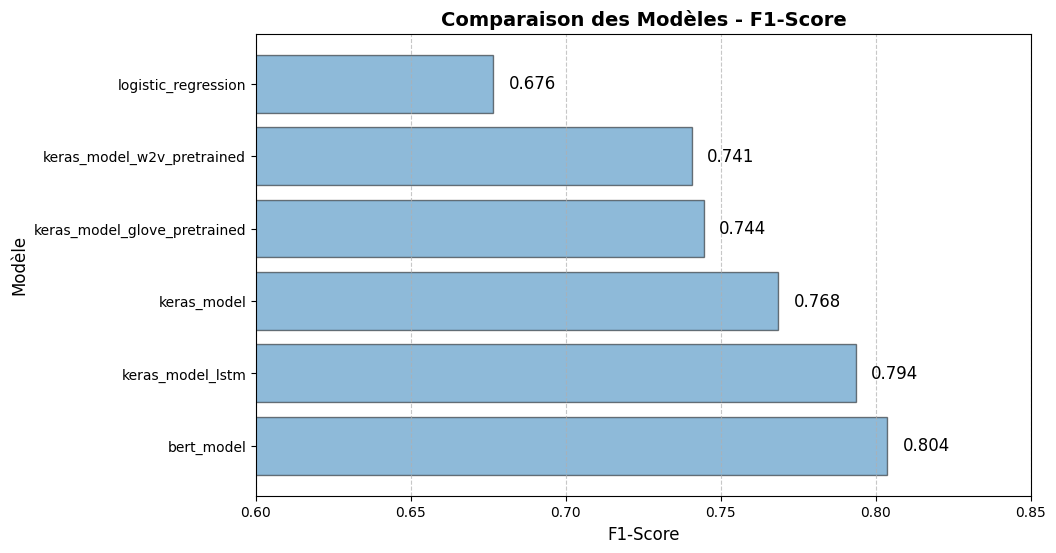

In [96]:
models = list(runs_df['params.model'])
f1_scores = list(runs_df['metrics.test_f1_score'])

# Création du diagramme en barres horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(models, f1_scores, alpha=0.5, edgecolor="black")

# Ajout des scores sur les barres
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"{score:.3f}", va='center', fontsize=12)

# Personnalisation du graphique
plt.xlabel("F1-Score", fontsize=12)
plt.ylabel("Modèle", fontsize=12)
plt.title("Comparaison des Modèles - F1-Score", fontsize=14, fontweight="bold")
plt.xlim(0.6, 0.85)
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Sauvegarde et affichage du graphique
plt.savefig("f1_score_comparison_improved.png", format="png", dpi=300)
plt.show()

Le **F1-score** est un bon indicateur dans ce cas car il représente le **compromis optimal entre la précision et le rappel**, qui ont la même importance, en garantissant que ni les faux positifs ni les faux négatifs ne sont privilégiés, assurant ainsi une évaluation équilibrée des performances du modèle.

Il est aussi important de tenir compte des temps d'infèrence et d'entrainement qui peuvent être des indicateurs détérminants pour le choix du modèle final à déployer en production.

Les résultats montrent que **BERT offre la meilleure performance globale**, notamment pour détecter les subtilités du langage. **Cependant, son coût computationnel élevé le rend moins adapté aux services Cloud gratuits** utilisés pour le déploiement. 

**LSTM a été retenu pour la production**, car il offre **un bon équilibre entre précision, rapidité et coût**, tout en restant compatible avec nos contraintes d’infrastructure.

## Modèle final

### Evaluation du modèle final

In [100]:
lstm_model_uri = load_model_uri(experiment_name, 'keras_model_lstm')

lstm_model = mlflow.tensorflow.load_model(lstm_model_uri)

lstm_model.save("output/lstm_model.keras")

In [102]:
report = mlflow.artifacts.load_text(lstm_model_uri + '_classification_report.txt')

print()
print(report)


              precision    recall  f1-score   support

     Class 0       0.79      0.79      0.79    159190
     Class 1       0.79      0.78      0.79    159211

    accuracy                           0.79    318401
   macro avg       0.79      0.79      0.79    318401
weighted avg       0.79      0.79      0.79    318401



L'évaluation du modèle montre une performance équilibrée entre les deux classes, avec une précision, un rappel et un f1-score d'environ 0.78 pour chacune. 

L'accuracy globale est également de 0.78, indiquant que le modèle effectue des prédictions correctes dans 78 % des cas. Les scores macro et weighted averages étant identiques, cela suggère que les classes sont équilibrées en termes de support (nombre d'échantillons)

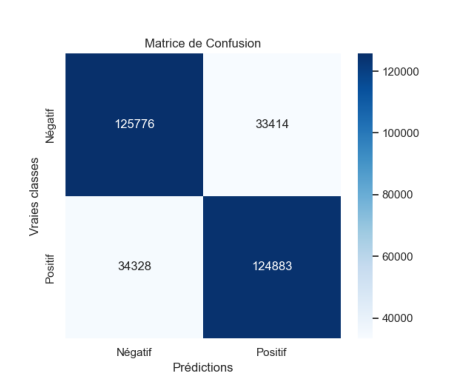

In [104]:
conf_matrix_path = mlflow.artifacts.download_artifacts(lstm_model_uri + '_confusion_matrix.png')

image = Image.open(conf_matrix_path)
plt.imshow(image)
plt.axis("off")
plt.show()

**Faux positifs** : Tweets négatifs classés comme positifs.

**Faux négatifs** : Tweets positifs classés comme négatifs.

- Taux de vrais négatifs (TN Rate) : 77.7% des vrais négatifs sont bien classés.
- Taux de faux positifs (FP Rate) : **22.3%** des négatifs sont mal classés comme positifs.
- Taux de vrais positifs (TP Rate ou recall) : 78.8% des vrais positifs sont bien détectés.
- Taux de faux négatifs (FN Rate) : **21.2%** des positifs sont mal classés comme négatifs.

Le modèle affiche une bonne capacité de classification avec environ 78% de prédictions correctes pour chaque classe, mais le taux d'erreur reste significatif (environ 22% de faux positifs et 21% de faux négatifs). 

Une optimisation pourrait être envisagée selon l'importance relative des faux négatifs ou des faux positifs dans l'application cible (par exemple, ajuster le seuil de classification).

On va mainteannt regarder quelques exemples d'erreurs de prédiction.

In [108]:
# Prétraiter les tweets 
X_test = data.loc[test_indices]['text'].map(preprocess_text)

y_test = data.loc[test_indices]['target']

# Charger le tokenizer utilisé pour entraîner le modèle LSTM
with open("output/tokenizer.pkl", 'rb') as handle:
    tokenizer = pickle.load(handle)

# Transformer les tweets en séquences de tokens et appliquer le padding pour LSTM
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Faire une prédiction avec le modèle LSTM
y_test_pred = (lstm_model.predict(X_test_pad) > 0.5).astype(int)

test_data = pd.DataFrame()

# Stocker les tweets et leurs labels réels
test_data['text'] = data.loc[test_indices]['text']

test_data['clean_text'] = X_test
test_data['label'] = y_test

# Stocker les prédictions du modèle LSTM
test_data["lstm"] = y_test_pred

# Identifier les erreurs de prédiction
test_data["lstm_error"] = test_data["label"] != test_data["lstm"]

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step


In [109]:
sample = [603167, 304523, 277068, 151475, 48874, 147274, 304523]

In [110]:
test_data.loc[sample]

,text,clean_text,label,lstm,lstm_error
603167,"Good Morning Twitter, im a bit irritated but i...",good morning twitter im bit irritated ok,0,1,True
304523,I can't see @JessicaHamby on Twitterberry,see twitterberry,0,1,True
277068,@omgrawr Wow wow wow! i can't wait to see it! ...,wow wow wow wait see come november,0,1,True
151475,Where's lexi??,lexi,0,1,True
48874,my favorite cart dude was no where to be found,favorite cart dude found,0,1,True
147274,I don't like the screamo version of face down,like screamo version face,0,1,True
304523,I can't see @JessicaHamby on Twitterberry,see twitterberry,0,1,True


Dans le tableau ci-dessus, on voit une liste d’exemples où le modèle LSTM a prédit "1" (positif), alors que la vraie classe était "0" (négatif). Ce sont des **Faux Positifs (FP)**, c'est-à-dire des tweets que le modèle considère comme positifs alors qu’ils ne le sont pas.

**Problème des mots mal interprétés**  

- `Good Morning Twitter, im a bit irritated but it will be ok` → Le modèle semble se baser sur `Good Morning` et `ok` pour prédire un sentiment positif, alors que le tweet contient `irritated`, ce qui exprime plutôt une frustration.
  
- `my favorite cart dude was no where to be found` → L’expression `favorite` peut donner une impression positive, mais le message exprime une **absence ou une déception**.

- `I don't like the screamo version of face down` → A cause de la suppression des stopwords, le modèle a ignoré `don't`, ce qui a inversé le sens du tweet et l’a fait passer pour positif.  

**Problème des tweets courts et ambigus**  

- `Where's lexi??` → Ce tweet est trop court, et sans contexte, le modèle peut avoir du mal à comprendre l’émotion sous-jacente.

- `I can't see @JessicaHamby on Twitterberry` → Le modèle a retenu "see Twitterberry" sans comprendre que "can't see" indique un **problème** et non une action positive.  

**Problème des expressions d'excitation avec négation (sarcasme)**  

- `@omgrawr Wow wow wow! i can't wait to see it! It comes out in november!` → Ce tweet est **positif**, mais il a été annoté comme négatif dans les labels. Il peut s'agir d'une erreur dans le dataset ou bien d'un tweet avec sarcasme.  


Pour améliorer le modèle on peut imaginer quelques solutions

- Améliorer le prétraitement  
   - Préserver les **négations** ("don't", "can't") pour éviter les inversions de sens.  
   - Faire attention à la **simplification excessive des tweets courts** qui peut supprimer du contexte.  

- Ré-entraîner le modèle avec des exemples difficiles  
   - Ajouter des cas où **les mots positifs sont dans des phrases négatives** pour que le modèle apprenne à mieux distinguer les contextes.  

- Ajuster le seuil de classification
   - On pourrait envisager d'essayer un seuil diffèrent de 0.5 pour la classification mais étant donné qu'on a autant de faux négatifs que de faux positifs cette solution n'est pas celle à privilégier.  

On va modifier la fonction de nettoyage pour garder quelques stopwords comme les mots de négation `can't` et `don't`

In [113]:
def preprocess_text_custom(text):
    text = text.lower().strip()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[@#]\w+', '', text)
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    text = re.sub(r"([?.!,¿])", r" ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    words = word_tokenize(text)
    custom_stopwords = [word for word in stopwords if word not in ['t', 'don', 'can']]
    words = [word for word in words if word not in custom_stopwords]
    words = [lemmatizer.lemmatize(word) for word in words]
    processed_text = ' '.join(words)
    return processed_text

In [114]:
preprocess_text("I don't like the screamo version of face down")

'like screamo version face'

In [115]:
preprocess_text_custom("I don't like the screamo version of face down")

'don t like screamo version face'

### Amélioration du modèle (pipeline de réentraînement)

Afin d'automatiser le réentraînement du modèle avec la nouvelle fonction de nettoyage, on va structurer tout le processus en **une pipeline**. 

Cela permettra de relancer facilement **l'entraînement à l'avenir avec de nouvelles données ou de nouveaux hyperparamètres**.

In [118]:
def preprocess_data(data, train_indices=None, val_indices=None, test_indices=None):
    # Appliquer le nettoyage sur la colonne 'text'
    data['clean_text'] = data['text'].map(preprocess_text_custom)

    # Séparer X (features) et y (target)
    X = data['clean_text']
    y = data['target']

    if train_indices is not None and val_indices is not None and test_indices is not None:
        # Utiliser les indices fournis pour créer les sets
        X_train, y_train = X.loc[train_indices], y.loc[train_indices]
        X_val, y_val = X.loc[val_indices], y.loc[val_indices]
        X_test, y_test = X.loc[test_indices], y.loc[test_indices]
    else:
        # Effectuer un split automatique si les indices ne sont pas fournis
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

    return X_train, y_train, X_val, y_val, X_test, y_test


def tokenize_and_pad(X_train, X_val, X_test, max_words=10000, max_len=100):
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    
    # Convertir en séquences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Appliquer le padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
    
    return X_train_pad, X_val_pad, X_test_pad, tokenizer

def save_model_and_tokenizer(model, tokenizer, model_path, tokenizer_path):
    model.save(model_path)
    
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Pour l'entraînement et l'évaluation du modèle, nous utiliserons les fonctions définies précédemment afin d'assurer une intégration fluide avec **MLflow**. 

Cela permettra de **logger automatiquement** tous les détails liés à l'entraînement, y compris les **hyperparamètres, les performances du modèle, les métriques de validation**, ainsi que l’évaluation sur l’ensemble de test. 

Cette approche garantit une **traçabilité complète** et facilite l'analyse comparative entre différentes itérations du modèle.

In [ ]:
# Prétraitement des données
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(data, train_indices, val_indices, test_indices)

# Tokenisation et vectorisation
X_train_pad, X_val_pad, X_test_pad, tokenizer = tokenize_and_pad(X_train, X_val, X_test)

with mlflow.start_run():

    model_name = 'keras_model_lstm_optimized'
    mlflow.log_param('Description', 'LSTM Bidirectional + Embedding appris')

    model = create_model(embedding_dim=embedding_dim, lstm=True)
    train_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), batch_size=64, epochs=5)
    evaluate_model(model, model_name, (X_train_pad, y_train), (X_val_pad, y_val), (X_test_pad, y_test))

    mlflow.end_run()

# Sauvegarder le modèle et le tokenizer
save_model_and_tokenizer(model, tokenizer, "output/keras_model_lstm_optimized.keras", "output/tokenizer_optimized.pkl")

In [120]:
lstm_model_optimized = tf.keras.models.load_model("output/keras_model_lstm_optimized.keras")

with open("output/tokenizer_optimized.pkl", 'rb') as handle:
    tokenizer_optimized = pickle.load(handle)

In [121]:
lstm_model_uri = load_model_uri(experiment_name, 'keras_model_lstm_optimized')

report = mlflow.artifacts.load_text(lstm_model_uri + '_classification_report.txt')

print()
print(report)


              precision    recall  f1-score   support

     Class 0       0.79      0.80      0.79    160000
     Class 1       0.79      0.78      0.79    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



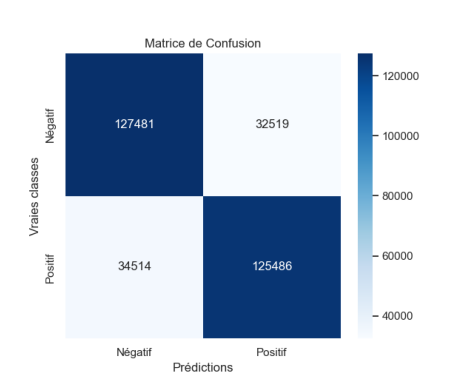

In [122]:
conf_matrix_path = mlflow.artifacts.download_artifacts(lstm_model_uri + '_confusion_matrix.png')

image = Image.open(conf_matrix_path)
plt.imshow(image)
plt.axis("off")
plt.show()

L’optimisation a permis une **légère amélioration du rappel pour la classe 0**, montrant une meilleure détection des vrais négatifs. 

Cela est confirmé par la **réduction des faux positifs (de 33 781 à 32 519)**, tout en maintenant une classification fiable des positifs. 

Cette **amélioration est due à une simple modification du nettoyage des données**, où nous avons **réintégré les mots `can't` et `don't`**, permettant au modèle de mieux détecter les négations et ainsi d’améliorer la classification des classes négatives. 

Ces résultats démontrent que le modèle est **plus robuste et affine mieux ses prédictions**.

In [124]:
test_data_sample = test_data.loc[sample]

X_test_sample = test_data_sample['text'].map(preprocess_text_custom)

X_test_sample_pad = pad_sequences(tokenizer_optimized.texts_to_sequences(X_test_sample), maxlen=max_len)

y_test_sample_pred = (lstm_model_optimized.predict(X_test_sample_pad) > 0.5).astype(int)

test_data_sample['clean_text_optimized'] = X_test_sample
test_data_sample["lstm_optimized"] = y_test_sample_pred

test_data_sample["lstm_optimized_error"] = test_data_sample["label"] != test_data_sample["lstm_optimized"]
test_data_sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


,text,clean_text,label,lstm,lstm_error,clean_text_optimized,lstm_optimized,lstm_optimized_error
603167,"Good Morning Twitter, im a bit irritated but i...",good morning twitter im bit irritated ok,0,1,True,good morning twitter im bit irritated ok,1,True
304523,I can't see @JessicaHamby on Twitterberry,see twitterberry,0,1,True,can t see twitterberry,0,False
277068,@omgrawr Wow wow wow! i can't wait to see it! ...,wow wow wow wait see come november,0,1,True,wow wow wow can t wait see come november,1,True
151475,Where's lexi??,lexi,0,1,True,lexi,1,True
48874,my favorite cart dude was no where to be found,favorite cart dude found,0,1,True,favorite cart dude found,1,True
147274,I don't like the screamo version of face down,like screamo version face,0,1,True,don t like screamo version face,0,False
304523,I can't see @JessicaHamby on Twitterberry,see twitterberry,0,1,True,can t see twitterberry,0,False


On remarque désormais que les tweets contenant ces mots, auparavant considérés comme stopwords, sont correctement classifiés. 

Par exemple, des phrases comme `I can't see @JessicaHamby on Twitterberry` ou `don’t like screamo version face` sont maintenant mieux interprétées, réduisant ainsi les erreurs de classification. 

Ces résultats démontrent que le modèle est plus robuste et affine mieux ses prédictions.